In [ ]:
!pip install emoji

     |████████████████████████████████| 170 kB 4.1 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=d0d97f95b7848c9aae01ea90af36b7922762cf95b680c17cf7876287e0ac7b5a
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


# Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import string, re, requests, csv
from google.colab import drive
from wordcloud import WordCloud
from gensim.corpora import WikiCorpus

In [ ]:
from nltk import word_tokenize, sent_tokenize
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Load dataset

In [ ]:
train_data = pd.read_csv('/content/train.csv')
train_data = train_data[['text', 'label']]
train_data.shape

(7967, 2)

In [ ]:
train_data['label'].value_counts()

neutral     2926
negative    2775
positive    2266
Name: label, dtype: int64

In [ ]:
test_data = pd.read_csv('/content/test.csv')
test_data = test_data[['text', 'label']]
test_data.shape

(1992, 2)

In [ ]:
test_data['label'].value_counts()

neutral     732
negative    694
positive    566
Name: label, dtype: int64

# EDA

## Wordcloud

In [ ]:
# positive comments before preprocessing
# data_pos = train_data[train_data['label'] == 'positive']

# all_text = ' '.join(word for word in data_pos['text'])
# wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
# plt.figure(figsize=(20,10))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.margins(x=0, y=0)
# plt.show()

In [ ]:
# negative comments before preprocessing
# data_neg = train_data[train_data['label'] == 'negative']

# all_text = ' '.join(word for word in data_neg['text'])
# wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
# plt.figure(figsize=(20,10))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.margins(x=0, y=0)
# plt.show()

In [ ]:
# neutral comments before preprocessing
# data_neut = train_data[train_data['label'] == 'neutral']

# all_text = ' '.join(word for word in data_neut['text'])
# wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
# plt.figure(figsize=(20,10))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.margins(x=0, y=0)
# plt.show()

In [ ]:
# value counts
train_data['label'].value_counts()

neutral     2926
negative    2775
positive    2266
Name: label, dtype: int64

# Preprocess

In [ ]:
# comments = data['text']
comments_train = train_data['text']
comments_test = test_data['text']

In [ ]:
# CLEANSING
def cleansing(data):

    # lowercasing
    data = data.lower()

    # remove punctuation
    punct = string.punctuation
    translator = str.maketrans(punct, ' '*len(punct))
    data = data.translate(translator)

    # remove ASCII dan unicode
    # data = data.encode('ascii', 'ignore').decode('utf-8')
    # data = re.sub(r'[^\x00-\x7f]',r'', data)
    
    # remove newline
    data = data.replace('\n', ' ')

    # remove digit
    pattern = r'[0-9]'
    data = re.sub(pattern, '', data)

    # remove extra space
    data = ' '.join(data.split())
    
    return data

import sys
# REMOVE EMOJI
# def remove_emoji(data):
#     emoji_pattern = re.compile("["
#                            u"\U0001F600-\U0001F64F"  # emoticons
#                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            u"\U00002702-\U000027B0"
#                            u"\U000024C2-\U0001F251"
#                            "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r' ', data)

# CONVERT EMOJIS
import emoji
import functools
import operator
import re

df_emoji = pd.read_csv('emoji_to_text.csv')
UNICODE_EMO = {row['emoji']:row['makna'] for idx,row in df_emoji.iterrows()}
def convert_emojis(text):
    # split emojis
    em_split_emoji = emoji.get_emoji_regexp().split(text)
    em_split_whitespace = [substr.split() for substr in em_split_emoji]
    em_split = functools.reduce(operator.concat, em_split_whitespace)
    text = ' '.join(em_split)

    # convert emojis
    for emot in UNICODE_EMO:
        text = re.sub(r'('+emot+')', "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()), text)
    return text.lower()

# CONSTRUCT KAMUS ALAY
text_path1 = 'https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/kbba.txt'
text_path2 = 'https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv'
kamus_alay1 = pd.read_csv(text_path1, delimiter="\t", header=None, names=['slang', 'formal'])
kamus_alay2 = pd.read_csv(text_path2)
kamus_alay = pd.concat([kamus_alay1, kamus_alay2[['slang', 'formal']]]).reset_index(drop=True)

dict_alay = dict()
for index, row in kamus_alay.iterrows():
    dict_alay[row['slang']] = row['formal']

# NORMALIZE COLLOQUIAL/ALAY
def normalize_text(data):
  word_tokens = word_tokenize(data)
  result = [dict_alay.get(w,w) for w in word_tokens]
  return ' '.join(result)


# CONSTRUCT STOPWORDS
rama_stopword = "https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/stopword.txt"
yutomo_stopword = "https://raw.githubusercontent.com/yasirutomo/python-sentianalysis-id/master/data/feature_list/stopwordsID.txt"
fpmipa_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/fpmipa-stopwords.txt"
sastrawi_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/sastrawi-stopwords.txt"
aliakbar_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/aliakbars-bilp.txt"
pebahasa_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/pebbie-pebahasa.txt"
elang_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-id.txt"
nltk_stopword = stopwords.words('indonesian')

path_stopwords = [rama_stopword, yutomo_stopword, fpmipa_stopword, sastrawi_stopword, 
                  aliakbar_stopword, pebahasa_stopword, elang_stopword]

# CUSTOM STOPWORDS
other = '''
admin mimin min minkes kalo nya username
'''

# gabungkan stopwords
stopwords_l = nltk_stopword
for path in path_stopwords:
    response = requests.get(path)
    stopwords_l += response.text.split('\n')

st_words = set(stopwords_l)
other_stopword = set(other.split())

stop_words = st_words | other_stopword

# REMOVE STOPWORDS
def remove_stopword(text, stop_words=stop_words):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return ' '.join(filtered_sentence)

In [ ]:
# full pipeline preprocess
def preprocess(data):
    data = cleansing(data)
    # data = remove_emoji(data)
    data = convert_emojis(data)
    data = normalize_text(data)
    data = remove_stopword(data)
    return data

## Rename username

In [ ]:
# rename username to @username
pattern = "(?:@)([A-Za-z0-9_](?:(?:[A-Za-z0-9_]|(?:\.(?!\.))){0,28}(?:[A-Za-z0-9_]))?)"
comments_train = comments_train.apply(lambda x: re.sub(pattern, "@username", x))
comments_test = comments_test.apply(lambda x: re.sub(pattern, "@username", x))

# preprocess
comments_train = comments_train.apply(lambda x: preprocess(x))
comments_test = comments_test.apply(lambda x: preprocess(x))

In [ ]:
# comments_train = comments_train.apply(lambda x: preprocess(x))
# comments_test = comments_test.apply(lambda x: preprocess(x))

In [ ]:
comments_train.head()

0                                                  api
1    turun maju canik wajah_tertawa_sampai_menangis...
2        prosentase kematian covid warga kota semarang
3    rapid test test swab pcr kawan-kawan dinkes se...
4                                      area pedurungan
Name: text, dtype: object

In [ ]:
comments_test.head()

0                             vaksin massal cek vaksin
1             kak coba coba ulang terima kasih infonya
2                           tugu graha padma isoman cc
3    terimakasih infonya berharap update informasi ...
4                                            ayo turun
Name: text, dtype: object

# Feature extraction (TF-IDF)

In [ ]:
y_train =  pd.get_dummies(train_data['label']).values
y_test =  pd.get_dummies(test_data['label']).values

y_train.shape, y_test.shape

((7967, 3), (1992, 3))

In [ ]:
y_train[1], y_train[0], y_train[5]

(array([0, 1, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([0, 0, 1], dtype=uint8))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer( min_df=2, max_df=0.95, max_features = 5000, ngram_range = (1, 3),
                              sublinear_tf = True )

comments_train_tfidf = vectorizer.fit_transform(comments_train).toarray()
comments_test_tfidf = vectorizer.transform(comments_test).toarray()

comments_train_tfidf.shape, comments_test_tfidf.shape

((7967, 5000), (1992, 5000))

In [ ]:
comments_train_tfidf = comments_train_tfidf.reshape(comments_train_tfidf.shape[0], comments_train_tfidf.shape[-1], 1)
comments_test_tfidf = comments_test_tfidf.reshape(comments_test_tfidf.shape[0], comments_test_tfidf.shape[-1], 1)

comments_train_tfidf.shape, comments_test_tfidf.shape

((7967, 5000, 1), (1992, 5000, 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D  

model = Sequential()
model.add(Conv1D(64,8, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(
      x=comments_train_tfidf,
      y=y_train,
      epochs=30,
      batch_size=32,
      validation_split=0.2
)

Epoch 1/30
200/200 [==============================] - 19s 29ms/step - loss: 1.0940 - accuracy: 0.3596 - val_loss: 1.0908 - val_accuracy: 0.3714
Epoch 2/30
200/200 [==============================] - 5s 27ms/step - loss: 1.0911 - accuracy: 0.3667 - val_loss: 1.0900 - val_accuracy: 0.3676
Epoch 3/30
200/200 [==============================] - 5s 27ms/step - loss: 1.0878 - accuracy: 0.3724 - val_loss: 1.0883 - val_accuracy: 0.3689
Epoch 4/30
200/200 [==============================] - 5s 27ms/step - loss: 1.0853 - accuracy: 0.3731 - val_loss: 1.0834 - val_accuracy: 0.3519
Epoch 5/30
200/200 [==============================] - 5s 27ms/step - loss: 1.0800 - accuracy: 0.3755 - val_loss: 1.0800 - val_accuracy: 0.3739
Epoch 6/30
200/200 [==============================] - 5s 27ms/step - loss: 1.0747 - accuracy: 0.3907 - val_loss: 1.0828 - val_accuracy: 0.3783
Epoch 7/30
200/200 [==============================] - 5s 27ms/step - loss: 1.0754 - accuracy: 0.3884 - val_loss: 1.0825 - val_accuracy: 0.380

In [ ]:
loss, accuracy = model.evaluate(comments_test_tfidf, y_test)

63/63 [==============================] - 1s 13ms/step - loss: 1.1002 - accuracy: 0.3675


# K-Fold

In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv1D(64,8, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(3, activation='softmax'))

    # compile
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [ ]:
mapper = {'neutral':0, 'positive':1, 'negative':2}
train_y = train_data['label'].map(mapper).values
test_y = test_data['label'].map(mapper).values

train_y[:2]

array([2, 0])

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)

# loop fold
cvscores = []
for idx_train, idx_val in kfold.split(comments_train_tfidf, train_y):
    # initialize model
    model = create_model()

    # Fit data to model
    history = model.fit(
      x=comments_train_tfidf[idx_train],
      y=y_train[idx_train],
      epochs=30,
      batch_size=32,
      verbose=0
      # validation_split=0.2
    )

    # Generate generalization metrics
    scores = model.evaluate(comments_train_tfidf[idx_val], 
                            y_train[idx_val], 
                            verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1]*100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

accuracy: 40.97%
accuracy: 36.64%
accuracy: 37.10%
accuracy: 41.62%
accuracy: 37.73%
38.81% (+/- 2.07%)


In [ ]:
# predict data test
model.evaluate(comments_test_tfidf, 
               y_test,
               verbose=0)

[1.0783575773239136, 0.37700802087783813]

# Keras Tuner

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.3 MB/s 


In [ ]:
import keras_tuner as kt
from tensorflow import keras

In [ ]:
def model_builder(hp):
    model = Sequential()

    model.add(Conv1D(filters=hp.Int('conv_1_filter', min_value=64, max_value=512, step=64),
                    kernel_size=hp.Choice('conv_1_kernel', values=[4,8,16]), 
                    activation='relu'))

    model.add(MaxPooling1D(pool_size=2))

    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=128, step=32), 
                    activation='relu'))
    
    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units2', min_value=16, max_value=64, step=16), 
                    activation='relu'))
    
    model.add(GlobalMaxPooling1D())

    model.add(Dense(3, activation='softmax'))

    # compile
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])
    return model

In [ ]:
tuner = kt.Hyperband(hypermodel=model_builder,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=30,
					 project_name='hyperband_tuner')

In [ ]:
tuner.search(comments_train_tfidf, 
             y_train, 
             epochs=30,
             verbose=1,
             shuffle=True,
             validation_split=0.2)

Trial 81 Complete [00h 02m 23s]
val_accuracy: 0.3958594799041748

Best val_accuracy So Far: 0.4447929859161377
Total elapsed time: 02h 02m 51s

Search: Running Trial #82

Hyperparameter    |Value             |Best Value So Far 
conv_1_filter     |384               |320               
conv_1_kernel     |16                |16                
units1            |96                |32                
units2            |32                |32                
learning_rate     |1e-05             |0.001             
tuner/epochs      |10                |30                
tuner/initial_e...|0                 |10                
tuner/bracket     |1                 |3                 
tuner/round       |0                 |3                 

Epoch 1/10
200/200 [==============================] - 25s 119ms/step - loss: 1.0964 - accuracy: 0.3840 - val_loss: 1.0962 - val_accuracy: 0.3959
Epoch 2/10
200/200 [==============================] - 23s 117ms/step - loss: 1.0959 - accuracy: 0.3899 - val_loss

KeyboardInterrupt: ignored

In [ ]:
tuner.results_summary()

In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
# conv_1_filter: 320
# conv_1_kernel: 16
# units1: 32
# units2: 32
# learning_rate: 0.001
 
def create_mode_tuned():
    model = Sequential()
    model.add(Conv1D(320,16, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(3, activation='softmax'))

    # compile
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [ ]:
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)

# loop fold
cvscores = []
for idx_train, idx_val in kfold.split(comments_train_tfidf, train_y):
    # initialize model
    model = create_mode_tuned()

    # Fit data to model
    history = model.fit(
      x=comments_train_tfidf[idx_train],
      y=y_train[idx_train],
      epochs=30,
      batch_size=32,
      verbose=0
      # validation_split=0.2
    )

    # Generate generalization metrics
    scores = model.evaluate(comments_train_tfidf[idx_val], 
                            y_train[idx_val], 
                            verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1]*100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

accuracy: 46.74%
accuracy: 47.68%
accuracy: 46.14%
accuracy: 44.95%
accuracy: 44.57%
46.01% (+/- 1.14%)


In [ ]:
# predict data test
model.evaluate(comments_test_tfidf, 
               y_test, 
               verbose=0)

[1.055172085762024, 0.4322289228439331]

In [ ]:
from tensorflow.keras.utils import plot_model


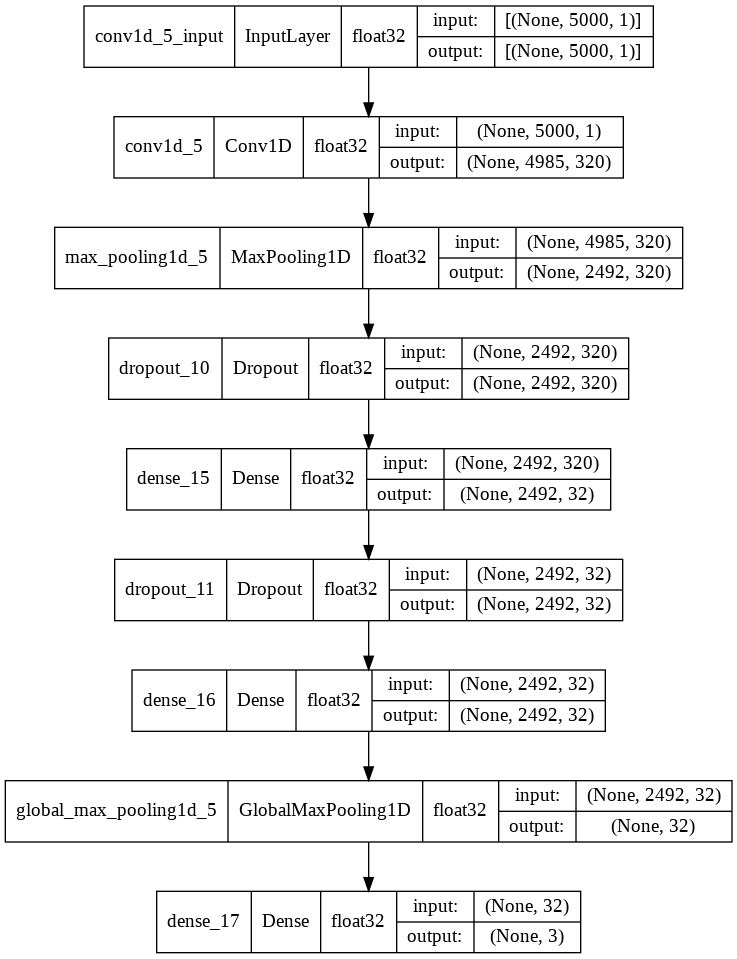

In [ ]:
plot_model(model, show_dtype=True, 
           show_layer_names=True, show_shapes=True,
           to_file="cnn.png")

In [ ]:
def predict_sentiment(sex, age, fare):
    df = pd.DataFrame.from_dict({'Sex': [sex], 'Age': [age], 'Fare': [fare]})
    df = encode_sex(df)
    df = encode_fares(df)
    df = encode_ages(df)
    pred = clf.predict_proba(df)[0]
    return {'Perishes': pred[0], 'Survives': pred[1]}

# CNN

In [ ]:
!pip install gradio

     |████████████████████████████████| 3.6 MB 7.6 MB/s 
     |████████████████████████████████| 206 kB 53.8 MB/s 
     |████████████████████████████████| 1.9 MB 49.6 MB/s 
     |████████████████████████████████| 961 kB 63.3 MB/s 
     |████████████████████████████████| 3.5 MB 56.0 MB/s 
     |████████████████████████████████| 63 kB 3.0 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4710 sha256=160670cbd01d5ae45c03d5a17463619bfca58c9dba59d5a1bd4bd74988fa8a7d
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-py3-none-any.whl size=3371 sha256=73803986135ded7e83a3aa034863ef603a996f081bf695229521fa70d8ec1b7a
  Stored in directory: /root/.cache/pip/wheels/28/c0/c4/44687421dab41455be93112bd1b0dee1f3c5a9aa27bee63708
Successfully built ffmpy flask-cachebuster


In [ ]:
import gradio as gr

In [ ]:
def get_encode(x):
  x=token1.texts_to_sequences(x)
  x=pad_sequences(x, maxlen=max_kata, padding='post')
  predict_x=model.predict(x)
  classes_x=np.argmax(predict_x,axis=1)
  return classes_x

In [ ]:
def get_encode(x):
  x=token1.texts_to_sequences(x)
  x=pad_sequences(x, maxlen=max_kata, padding='post')
  return x

In [ ]:
def get_encode(x):
  x=token1.texts_to_sequences(x)
  x=pad_sequences(x, maxlen=max_kata, padding='post')
  predict_x=model.predict(x)
  print(predict_x)
  prob_x=np.max(predict_x, axis=1)
  classes_x=np.argmax(predict_x,axis=1)
  return classes_x, round(prob_x[0])

In [ ]:
get_encode('Semarang hebat')

[[0.23449636 0.7491797  0.01632398]
 [0.26482272 0.354344   0.3808333 ]
 [0.01759321 0.94845283 0.03395393]
 [0.3004989  0.36732167 0.33217943]
 [0.28680444 0.34133515 0.3718604 ]
 [0.3004989  0.36732167 0.33217943]
 [0.23350278 0.46493992 0.3015573 ]
 [0.2343699  0.396893   0.36873713]
 [0.28680444 0.34133515 0.3718604 ]
 [0.2807975  0.36019853 0.35900396]
 [0.26482272 0.354344   0.3808333 ]
 [0.04548858 0.9413951  0.01311627]
 [0.3004989  0.36732167 0.33217943]
 [0.13193291 0.7927755  0.0752916 ]]


(array([1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1]), 1)

In [ ]:
x=['Semarang hebat']
x=get_encode(x)

[0.9838154]


In [ ]:
model.predict(x)

array([[4.1386651e-05, 8.5382519e-05, 9.9987316e-01]], dtype=float32)

In [ ]:
predict_x=model.predict(x)
classes_x=np.argmax(predict_x,axis=1)
classes_x

array([2])

In [ ]:
hasil=classes_x

In [ ]:
gradio_ui = gr.Interface(
    fn=get_encode,
    title="Sentiment Analysis",
    description="Enter some text and see if the Distilbert model can gauge the sentiment correctly",
    inputs=gr.inputs.Textbox(lines=10, label="Paste some text here"),
    outputs=[
        gr.outputs.Textbox(label="Sentiment Label"),
        gr.outputs.Textbox(label="Sentiment Score"),
    ],
)

In [ ]:
gradio_ui.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://59083.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7863/',
 'https://59083.gradio.app')

In [ ]:
gr.Interface(fn=get_encode, inputs=["text"], outputs="text").launch()

In [ ]:
iface=